In [1]:
import ast
import numpy as np
import torch
import matplotlib.pyplot as plt

from constants import DEVICE, FREQS_MHZ
from modules.data_utils import H5LazyDataset, DataProcessor

In [2]:
h5_lazy_dataset = H5LazyDataset(
    'data/train/train.h5', 'waveforms', 'labels',
    data_transforms=(
        lambda data: torch.tensor(data, dtype=torch.complex64),
        torch.fft.fft,
        torch.abs,
        lambda data: data.to(dtype=torch.float64),
        lambda data: (data - data.min()) / (data.max() - data.min()),
        torch.fft.fftshift,
    ),
    label_transforms=(
        lambda _bytes: _bytes.decode('utf-8'),
        ast.literal_eval,
        lambda label: torch.tensor(label, dtype=torch.float64),
        DataProcessor.generate_centers,
    ),
)

In [9]:
waveform: torch.Tensor
label: torch.Tensor
waveform, label = h5_lazy_dataset[9119]

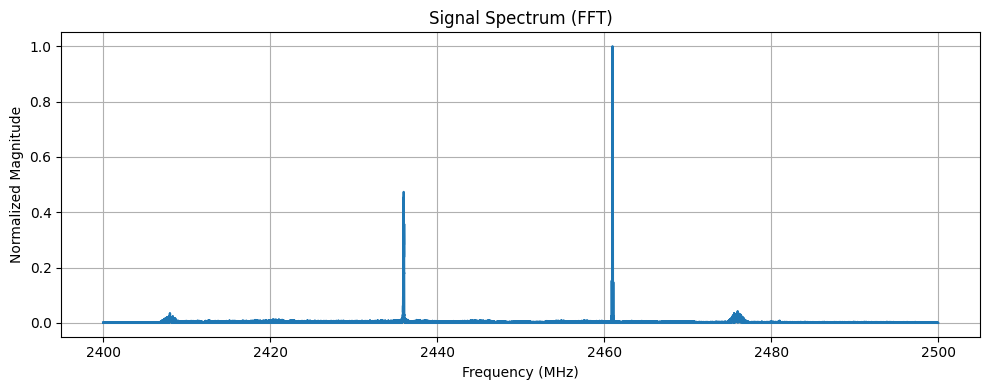

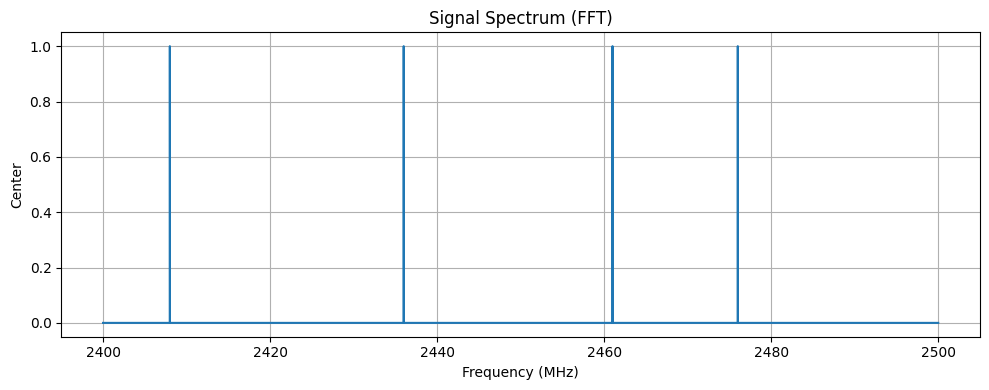

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(FREQS_MHZ, waveform)
plt.title("Signal Spectrum (FFT)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Normalized Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(FREQS_MHZ, label)
plt.title("Center Spectrum (FFT)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Center")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(waveform.dtype)
print(label.dtype)